In [36]:
import numpy as np
import matplotlib.pyplot as plt
from getdist.mcsamples import loadMCSamples
from getdist.mcsamples import MCSamples
from getdist import plots
from classy_sz import Class as Class_sz
# !export JAX_PLATFORMS=cpu

In [37]:
%%time
cosmo_params = {
'omega_b': 0.02242,
'omega_cdm':  0.11933,
'H0': 67.66, # use H0 because this is what is used by the emulators.
'tau_reio': 0.0561,
'ln10^{10}A_s': 3.047,
'n_s': 0.9665,
}

# initialize computation
classy_sz = Class_sz()
classy_sz.set(cosmo_params)
classy_sz.set({
'output':' ',
'jax': 1,
})
classy_sz.compute_class_szfast()

CPU times: user 6.8 ms, sys: 2.65 ms, total: 9.45 ms
Wall time: 5.02 ms


In [38]:
# Define chain directory
# chain_dir = r'/Users/licongxu/Work/tszpower/chains/tszpower_chain'
# chain_dir = r'/Users/licongxu/Desktop/chains/tszpower_chain'
samples_dir = r"/Users/licongxu/Desktop/samples_NLE_ds.txt"
data = np.loadtxt(samples_dir, skiprows=1)
# Define the parameter names and (optional) pretty labels:
names = ['logA', 'omega_b', 'omega_cdm', 'H0', 'n_s', 'B', 'A_cib', 'A_rs', 'A_ir']
labels = [r'\logA', r'\omega_b', r'\omega_{cdm}', r'H_0', r'n_s', r'B', r'A_{\rm cib}', r'A_{\rm rs}', r'A_{\rm ir}']

# Load MCMC samples
# ignore_row = 0.2
readsamps = MCSamples(samples = data, names=names, labels=labels)
print(readsamps.samples)
print(readsamps.getParamNames())

Removed no burn in
[[2.70381927e+00 2.03725416e-02 1.16581842e-01 ... 1.07412552e-02
  5.27749993e-02 2.18698835e+00]
 [2.71037197e+00 2.01336723e-02 1.16879083e-01 ... 1.11735445e-02
  5.47475368e-03 2.48650599e+00]
 [2.70807147e+00 2.00021565e-02 1.16491802e-01 ... 2.43348926e-02
  4.60007170e-04 2.05707407e+00]
 ...
 [2.85544515e+00 2.12783124e-02 1.10728100e-01 ... 1.28667860e-03
  1.12218037e-03 2.67780757e+00]
 [2.85400581e+00 2.07937546e-02 1.10517919e-01 ... 7.43705127e-03
  1.21860392e-02 2.25289559e+00]
 [2.86150765e+00 2.00502835e-02 1.10098571e-01 ... 8.18615500e-03
  3.57929431e-02 1.74930143e+00]]
logA	\logA
omega_b	\omega_b
omega_cdm	\omega_{cdm}
H0	H_0
n_s	n_s
B	B
A_cib	A_{\rm cib}
A_rs	A_{\rm rs}
A_ir	A_{\rm ir}



In [39]:
p = readsamps.getParams()
print('Adding derived parameters')

# Compute sigma8 for each sample
sigma8_values = []

for i in range(len(p.logA)):
    logA = p.logA[i]
    omega_cdm = p.omega_cdm[i]
    omega_b = p.omega_b[i]
    H0 = p.H0[i]
    n_s = p.n_s[i]
    cosmo_params = {
        'omega_b': omega_b,
        'omega_cdm': omega_cdm,
        'H0': H0,
        'ln10^{10}A_s': logA,
        'n_s': n_s,
    }

    A_s_dict = cosmo_params
    sigma8 = classy_sz.get_sigma8_and_der(params_values_dict=A_s_dict)[1]  # Compute sigma8
    sigma8_values.append(sigma8)


# Convert list to numpy array
sigma8_values = np.array(sigma8_values)

# Add derived parameters to MCMC samples
readsamps.addDerived(sigma8_values, name='sigma8', label=r'\sigma_8')
# Compute derived parameter: ln(1/A_rs)
ln_1_A_rs = np.log(1.0 / p.A_rs)
# ln_1_A_rs = np.log(1.0 / np.abs(p.A_rs))

# Add derived parameter to samples
readsamps.addDerived(ln_1_A_rs, name='ln_1_A_rs', label=r'\ln(1/A_\mathrm{rs})')
print("Derived parameters added successfully.")

Adding derived parameters
Derived parameters added successfully.


In [40]:
p.logA

array([2.70381927, 2.71037197, 2.70807147, ..., 2.85544515, 2.85400581,
       2.86150765])

In [41]:
# Compute h and Omega_m for each sample
h = p.H0 / 100.0  # Compute h
Omega_m = (p.omega_cdm + p.omega_b) / h**2  # Compute Omega_m

# Compute F = sigma8 * (Omega_m / B)^0.40 * h^-0.21
F_values = sigma8_values * (Omega_m / p.B) ** (0.40) * h ** (-0.21)

# Add F as a derived parameter
readsamps.addDerived(F_values, name='F', label=r'F = \sigma_8 (\Omega_m / B)^{0.40} h^{-0.21}')

# **Force GetDist to recognize the new parameter**
readsamps.updateBaseStatistics()

print("Derived parameter F added successfully.")


Derived parameter F added successfully.


In [42]:
Fs = readsamps.getInlineLatex('F',limit=1)
Acib = readsamps.getInlineLatex('A_cib',limit=1)
ln_1_A_rs = readsamps.getInlineLatex('ln_1_A_rs',limit=1)
Air = readsamps.getInlineLatex('A_ir',limit=1)
print('F: ',Fs)
print('A_cib: ',Acib)
print('ln_1_A_rs: ',ln_1_A_rs)
print('A_ir: ',Air)

F:  F = \sigma_8 (\Omega_m / B)^{0.40} h^{-0.21} = 0.5064^{+0.0047}_{+0.00031}
A_cib:  A_{\rm cib} = 0.0080^{+0.0020}_{-0.0082}
ln_1_A_rs:  \ln(1/A_\mathrm{rs}) = 4.11^{+0.78}_{-1.5}
A_ir:  A_{\rm ir} = 1.6^{+1.2}_{-1.6}


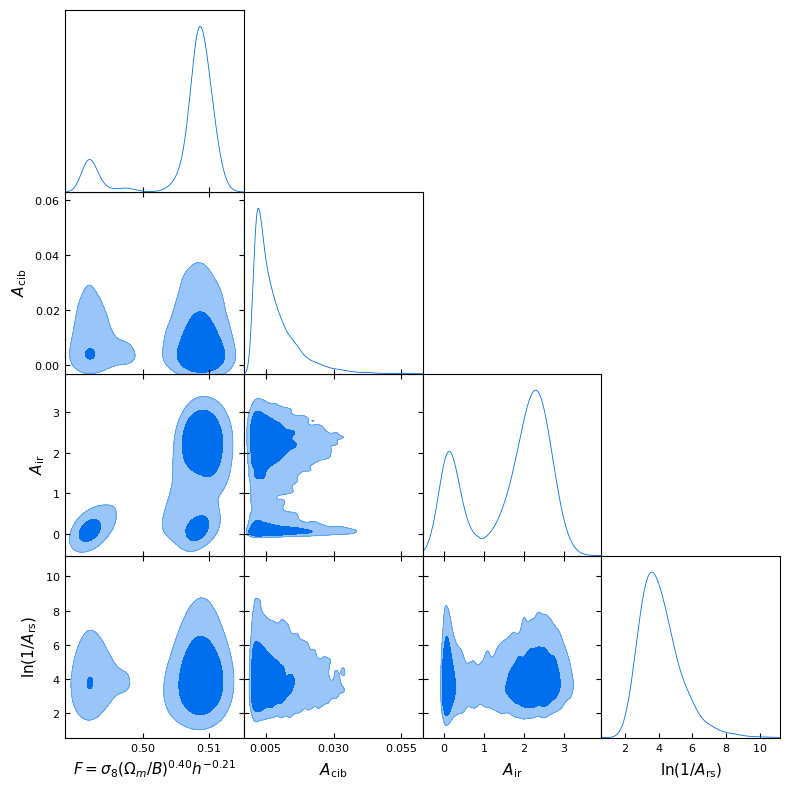

In [43]:
# Define parameters to plot
params_to_plot = ['F', 'A_cib', 'A_ir','ln_1_A_rs']

# Create a triangle plot (corner plot)
g = plots.get_subplot_plotter()
g.triangle_plot(readsamps, params_to_plot, filled=True)

# Adjust axis limits for specific parameters
# g.subplots[0, 0].set_xlim(0.42, 0.52)  # Adjust x-axis limit for 'F'
# g.subplots[1, 1].set_xlim(0, 1)  # Adjust x-axis limit for 'A_cib'
# g.subplots[2, 2].set_xlim(1.5, 2.5)  # Adjust x-axis limit for 'A_ir'
# g.subplots[3, 3].set_xlim(-1.5, 6) # Adjust x-axis limit for 'ln_1_A_rs'

# Show the plot
plt.show()